In [ ]:
!pip3 install torchviz
import os
import cv2
import seaborn 
import numpy as np
import pandas as pd 
import random
import tqdm
from tqdm import notebook
import albumentations as A
from albumentations import pytorch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision
import torchviz
from torchviz import make_dot

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=02212c2e87250c4cc3c8af0dbb7902d69dd451422b35dc51f78fa1818da13434
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
images_dir = "/content/drive/MyDrive/U-NET/Dataset"
train_images_dir = os.path.join(images_dir, 'train')
val_images_dir = os.path.join(images_dir, 'val')
working_dir = "/content/drive/MyDrive/U-NET"
weights_path = os.path.join(working_dir, 'unet4_weights_tconv.pth')
logs_path = os.path.join(working_dir, 'logs')

In [ ]:
class Generator(object):
    def __init__(self, images_dir, batch_size, is_augmentation, shuffle = True, rescale = 1.00, target_size = (128,128)):
        super(Generator, self).__init__()
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.rescale = rescale
        self.shuffle = shuffle
        self.is_augmentation = is_augmentation
        self.target_size = target_size
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.current_step = 0
        self.count_images = len(self.filenames)
        self.avaialable_steps = int(self.count_images // self.batch_size)
        self.transforms = A.Compose([
                                     A.Rotate(25),
                                     A.OneOf([
                                              A.RGBShift(), A.HueSaturationValue()
                                     ]),
                                     A.OneOf([
                                              A.CLAHE(), 
                                              A.RandomBrightnessContrast(),
                                              A.RandomGamma()
                                     ]),
        ])

    def augmenatate(self, batch):
        batch = batch.astype(np.uint8)
        batch = [self.transforms(image=image, mask=mask) for (image,mask) in batch]
        batch = np.array([(transformed['image'], transformed['mask']) for transformed in batch], dtype=np.float32)
        return batch

    def generate_batch(self):
        start = self.current_step*self.batch_size
        stop = (self.current_step+1)*self.batch_size
        filenames_batch = self.filenames[start:stop]

        images_batch = [cv2.imread(filename) for filename in filenames_batch]

        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])

        images_batch = np.array([(image[:, :256], image[:, 256:]) for image in images_batch])

        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image,mask) in images_batch], dtype = np.float32)

        if self.is_augmentation:
            images_batch = self.augmenatate(images_batch)

        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])

        images_batch /= self.rescale

        images_batch = np.moveaxis(images_batch, 1, 0)

        return torch.Tensor(images_batch)

    def __next__(self):
        if self.current_step > self.avaialable_steps:
            self.current_step = 0
        images, masks = self.generate_batch()
        self.current_step+=1
        return images, masks

    def __len__(self):
        return self.avaialable_steps

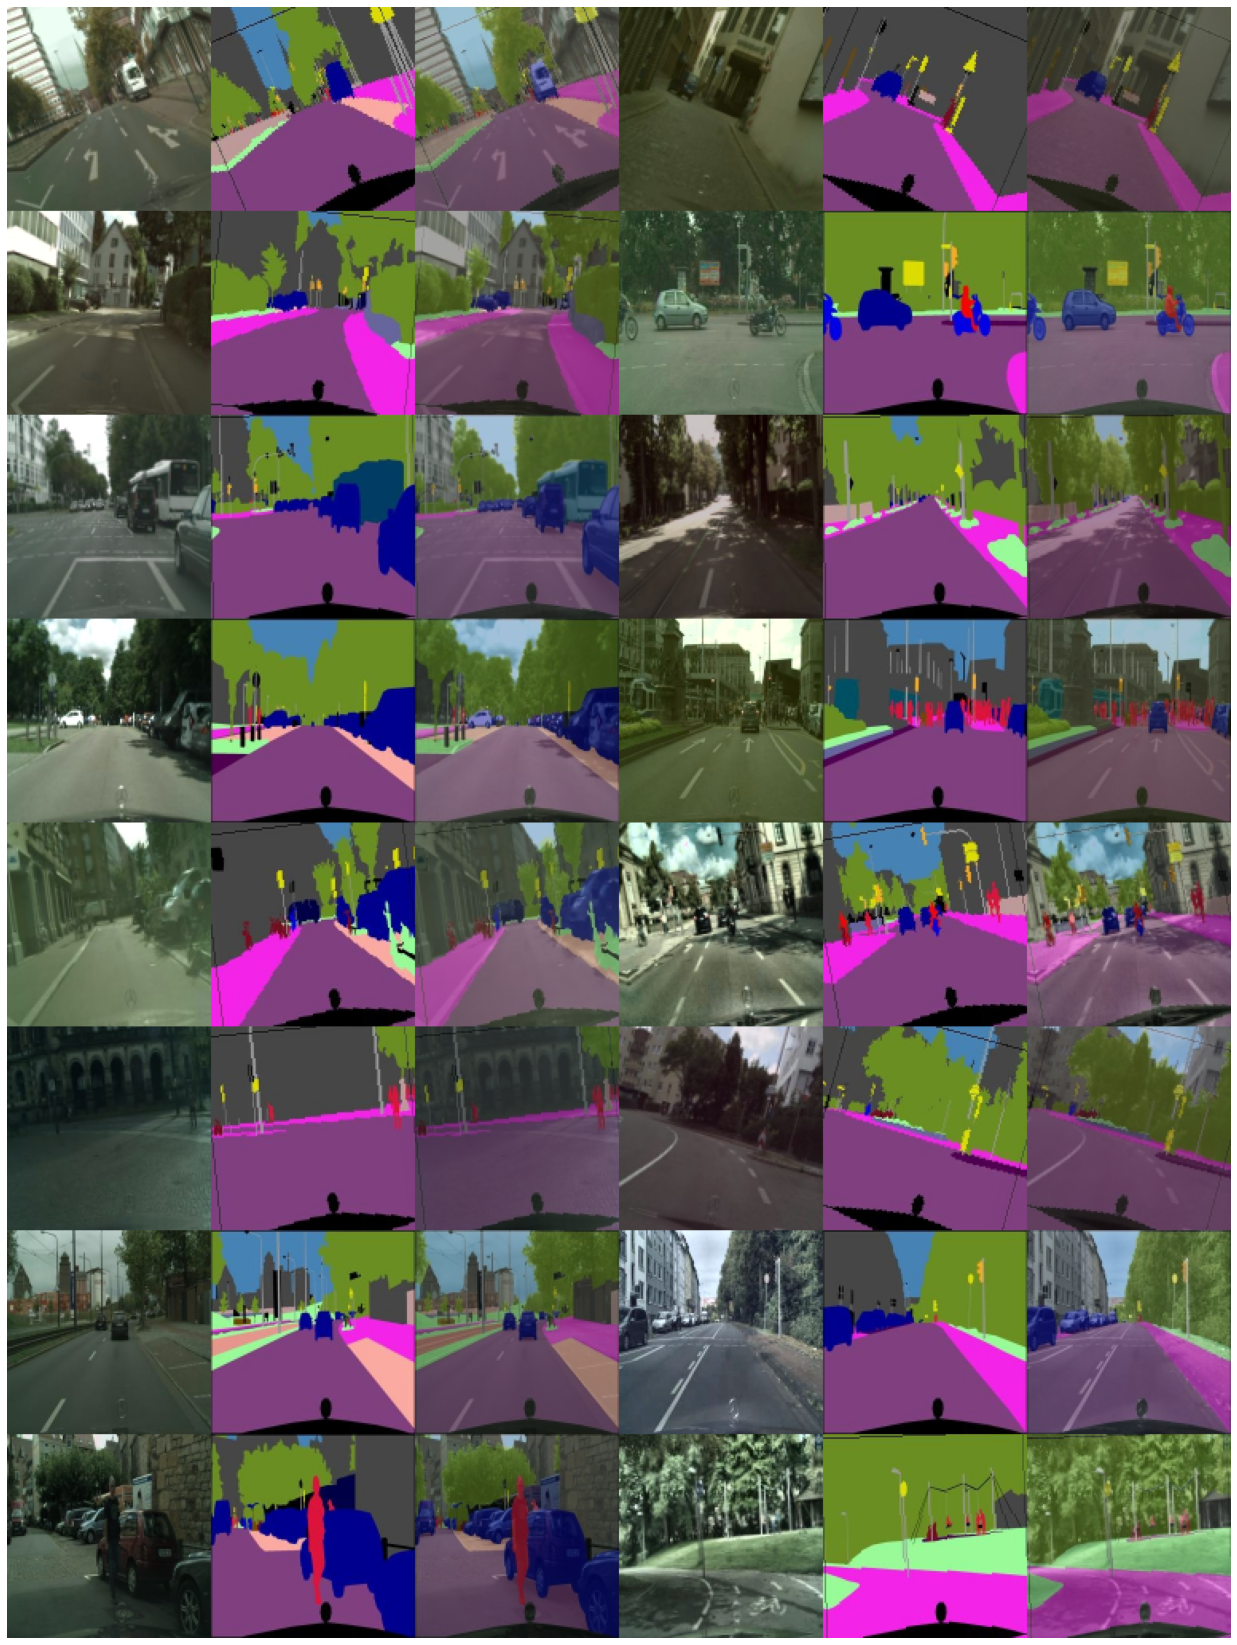

In [ ]:
def show_examples(num_cols):
    stacks = []
    dataloader = Generator(images_dir= train_images_dir, batch_size= 8, is_augmentation= True, rescale= 255.0)

    for iteration in range(num_cols):
        images, masks = next(dataloader)
        images, masks = images.numpy(), masks.numpy()
        images, masks = np.concatenate(np.moveaxis(images, 1, -1)), np.concatenate(np.moveaxis(masks, 1, -1))
        embedded = (images + masks)/2
        stack = np.hstack([images, masks, embedded])
        stacks.append(stack)

    result = np.hstack(stacks)
    plt.figure(figsize=(30,30))
    plt.axis('off')
    plt.imshow(result)

show_examples(2)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.double_conv(x)

    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear = False):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        factor = 2 if bilinear else 1

        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


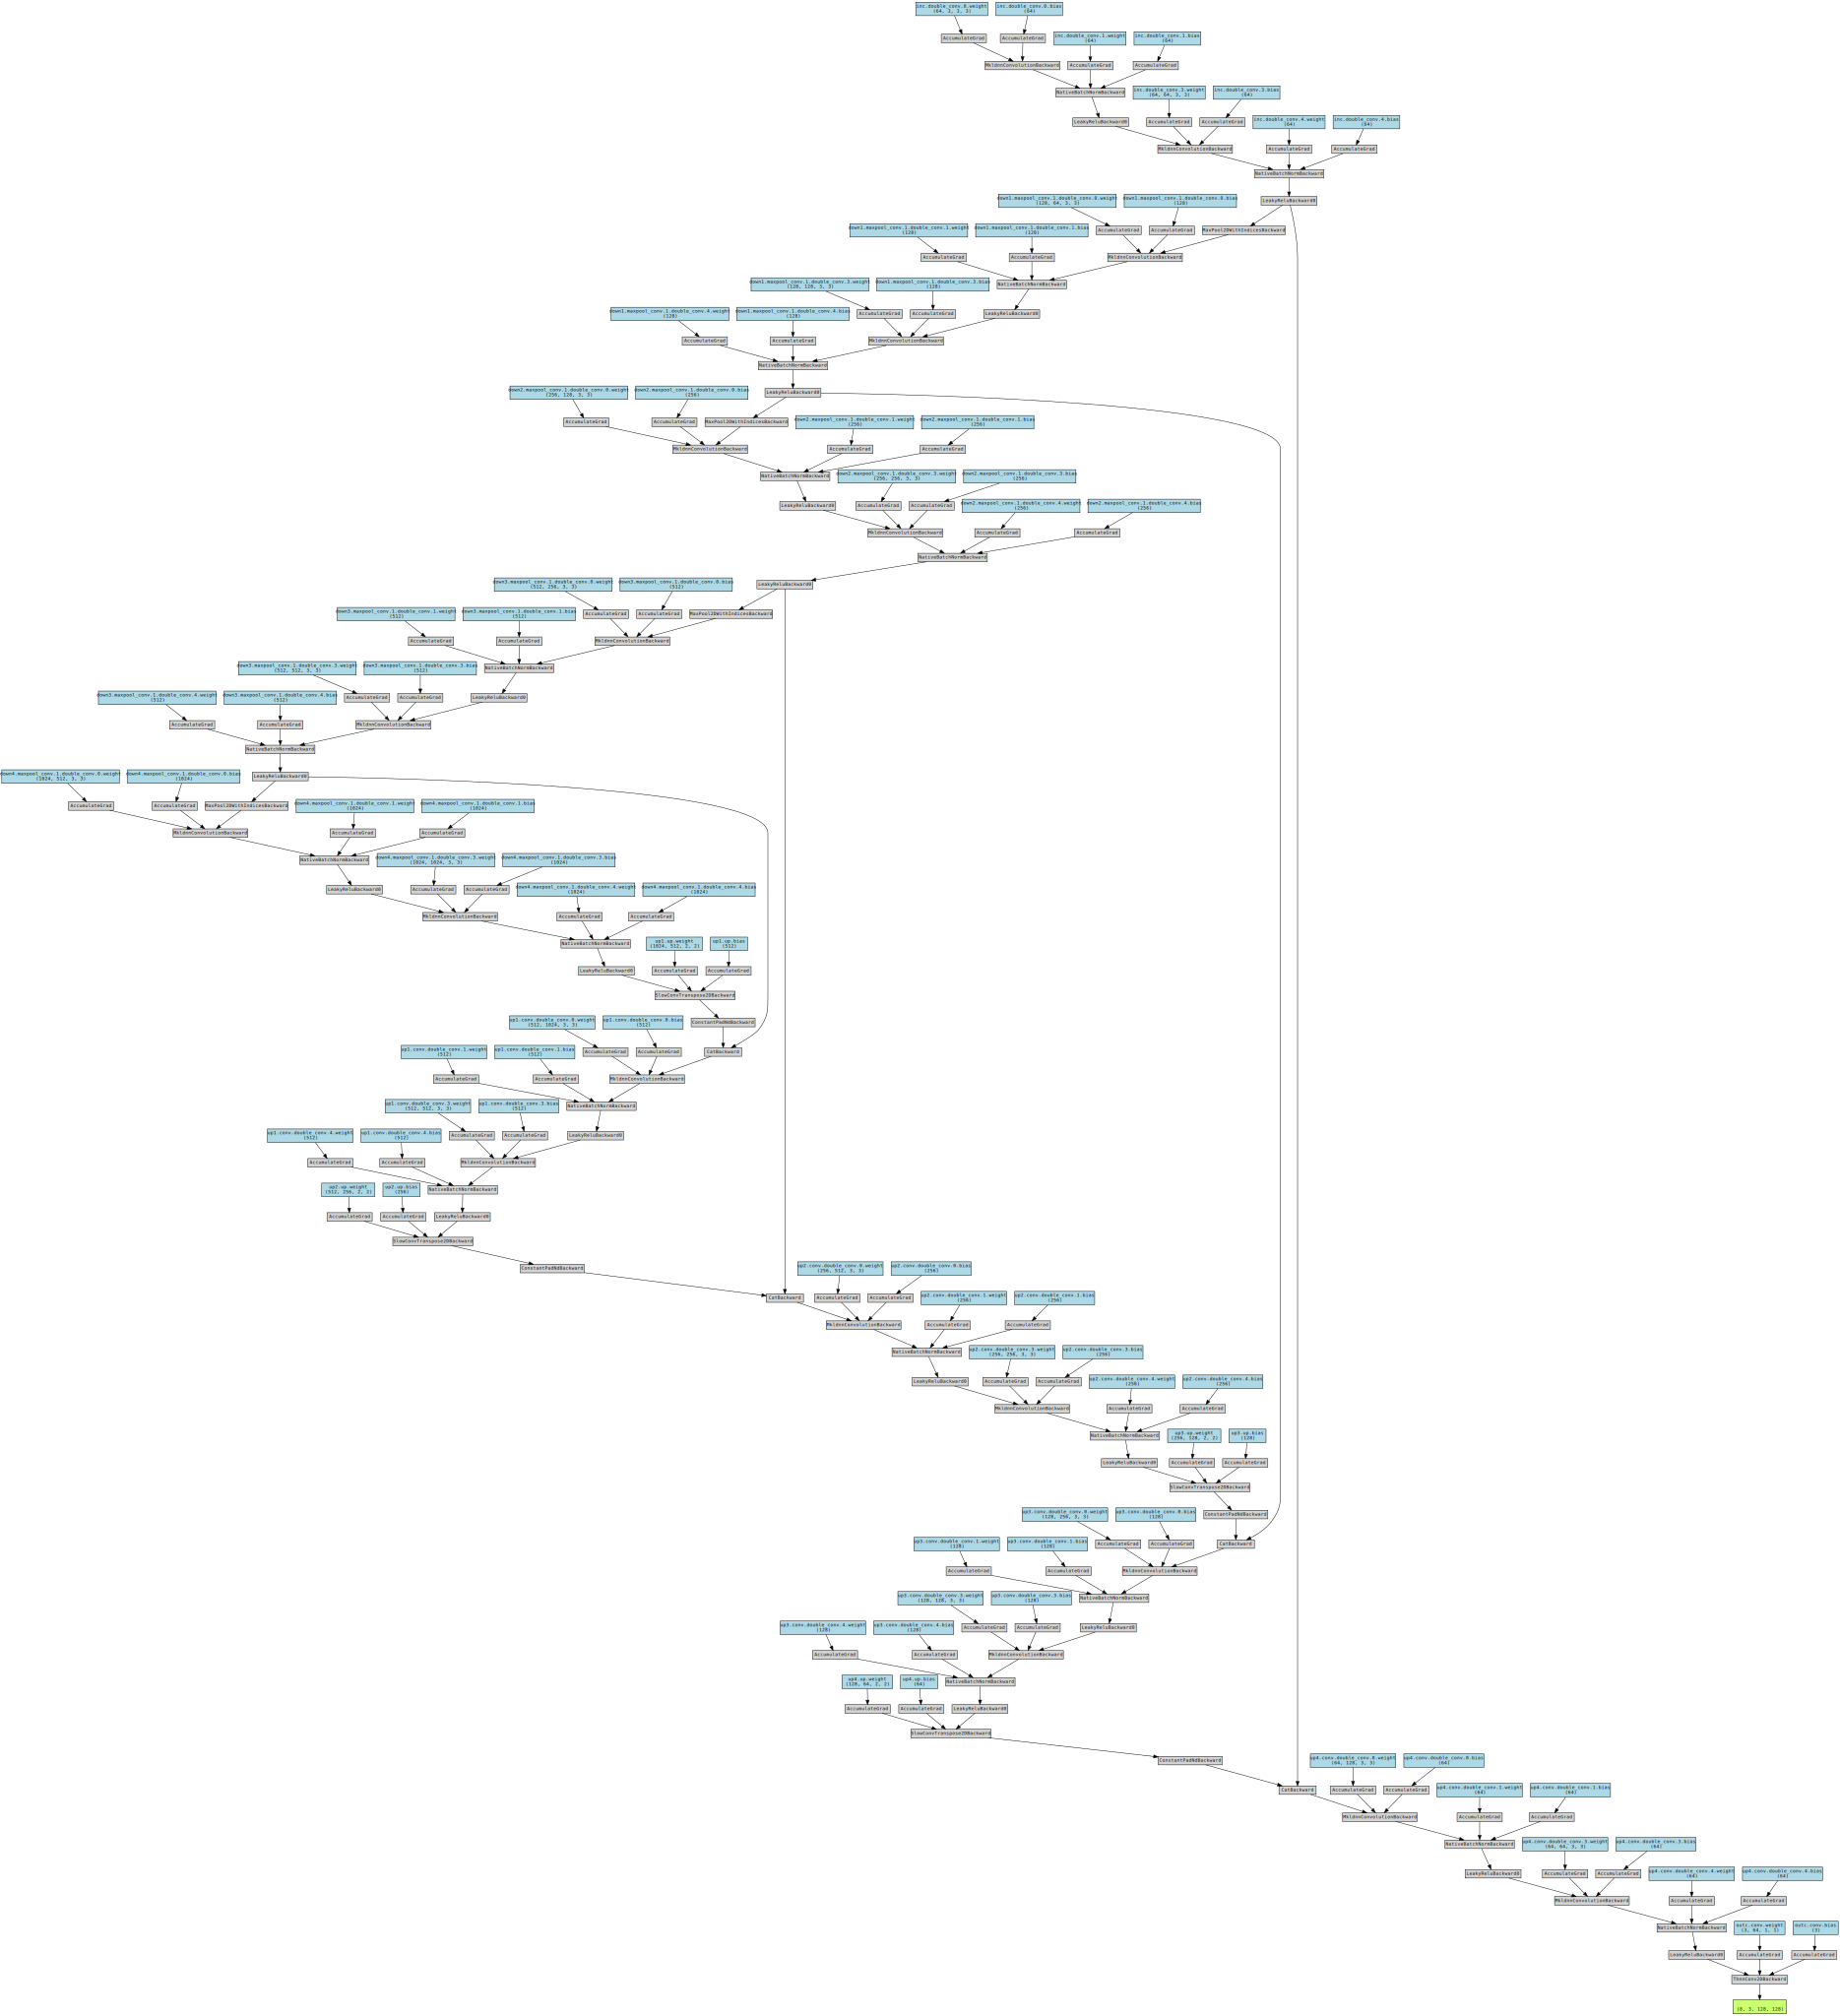

In [ ]:
unet = UNet(n_channels=3, n_classes=3, bilinear=False)
x = torch.zeros(8, 3, 128, 128, dtype = torch.float, requires_grad=False)
out = unet(x)
make_dot(out, params = dict(list(unet.named_parameters())))

In [ ]:
optimizer = torch.optim.Adam(params = unet.parameters(), 
                             lr=1e-4, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)

criterion = torch.nn.BCEWithLogitsLoss()

history = dict(train_loss = [], 
               train_dice_coeff = [], 
               test_loss = [], 
               test_dice_coeff = [])

def dice_coeff(pred, target):
    pred = (pred > 0).float()
    return 2. * (pred*target).sum() / (pred+target).sum()
            
def training(model, epochs, batch_size):
 
    train_generator = Generator(images_dir = train_images_dir, batch_size = batch_size, is_augmentation = True, rescale = 255.0)
    test_generator = Generator(images_dir = val_images_dir, batch_size = batch_size, is_augmentation = False, rescale = 255.0)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    main_pbar = tqdm.notebook.tqdm(range(epochs))
    main_pbar.set_description('common progress ')
    
    for epoch in main_pbar:
        running_params = dict(train_loss = [], 
                               train_dice_coeff = [], 
                               test_loss = [], 
                               test_dice_coeff = [])
        train_pbar = tqdm.notebook.tqdm(range(len(train_generator)))
        
        for step in train_pbar:
            
            train_images, train_masks = next(train_generator)
            train_images, train_masks = train_images.to(device), train_masks.to(device)

            optimizer.zero_grad()

            train_predictions = model(train_images)

            train_loss = criterion(train_predictions, train_masks)
            train_loss.backward()

            train_dice_coeff = dice_coeff(pred = train_predictions, target = train_masks)

            optimizer.step()
        
        
       
            with torch.no_grad():

                test_images, test_masks = next(test_generator)
                test_images, test_masks = test_images.to(device), test_masks.to(device)

                test_predictions = model(test_images)

                test_loss = criterion(test_predictions, test_masks)

                test_dice_coeff = dice_coeff(pred = test_predictions, target = test_masks)
                
            

            current_metrics = dict(train_loss = [train_loss.item(), ], 
                                   train_dice_coeff = [train_dice_coeff.item(), ], 
                                   test_loss = [test_loss.item(),], 
                                   test_dice_coeff = [test_dice_coeff.item(),])
            

            running_params.update(current_metrics)

            mean_metrics = dict(zip(running_params.keys(), [(sum(tensor) / (step + 1)) for tensor in running_params.values()]))

            train_pbar.set_postfix(mean_metrics)

            torch.cuda.empty_cache()
        
        history.update(running_params)
        best_loss = max(history['test_loss'])
        best_loss_index = history['test_loss'].index(best_loss)
        current_loss_index = history['test_loss'].index(test_loss.item())
        if abs(current_loss_index - best_loss_index) >= 5:
            for param_group in optim.param_groups:
                if param_group['lr'] * 0.1 > 1e-6:
                    print('reduce learning rate to', {param_group['lr'] * 0.1})
                    param_group['lr'] *= 0.1

training(model = unet, epochs = 20, batch_size = 32)
torch.save(unet.state_dict(), weights_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
model = UNet(n_channels=3, n_classes=3, bilinear=False)
model.load_state_dict(torch.load(weights_path))
model.eval()

In [ ]:
def show_final_results(num_cols):
    generator = Generator(images_dir = val_images_dir, 
                           batch_size = 8, 
                           is_augmentation = True, 
                           rescale = 255.0)
    result = []
    for iteration in range(num_cols):
        images, masks = next(generator)
        prediction = torch.sigmoid(model(images))
        prediction = prediction.cpu().detach().numpy()
        prediction = np.moveaxis(prediction, 1, -1)
        masks = np.moveaxis(masks.numpy(), 1, -1)
        images = np.moveaxis(images.numpy(), 1, -1)
        prediction = np.concatenate(prediction)
        images = np.concatenate(images)
        masks = np.concatenate(masks)
        merged = np.add(images, prediction) / 2
        outputs = np.hstack([images, masks, prediction, merged])
        result.append(outputs)
    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)

show_final_results(num_cols = 2)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'model parameters: {params}')